# Social network analysis

## Load input csv file

In [129]:
import pandas as pd

# load input csv file
def loadData(path = "./casts.csv", nrows=10000):
    df = pd.read_csv(path, nrows=nrows, delimiter=";")
    df.columns = ["movieId", "movieTitle", "actorName", "roleType", "roles"]
    return df


df = loadData()

## Create graph

In [130]:
import networkx as nx
import itertools as itertools

# create graph from dataframe (nodes - actors), edge between actors means, the casts in the same movie
def createGraph(dataFrame):
    actors = df.actorName.unique()
    
    G = nx.Graph()
    
    # add nodes        
    G.add_nodes_from(actors)
    
    # create dictionary, where keys are movie titles, values are lists of actor names
    movieActorDict = {}
    for index, row in df.iterrows():
        if row.movieTitle in movieActorDict:
            movieActorDict[row.movieTitle].append(row.actorName)
        else:
            movieActorDict[row.movieTitle] = [row.actorName]
            
    # add edges    
    for movie, actors in movieActorDict.items():
        for actorsPair in itertools.combinations(actors, 2):
            G.add_edge(actorsPair[0], actorsPair[1])
    
    return G


graph = createGraph(df)

## General statistics

In [131]:
# compute general statistics
def computeGeneralStatistics(G):
    maxDegree = -1
    minDegree = len(G.nodes) - 1
    degreesSum = 0
    for node in G.nodes:
        degreesSum += G.degree(node)
        if G.degree(node) > maxDegree:
            maxDegree = G.degree(node)
        if G.degree(node) < minDegree:
            minDegree = G.degree(node)
            
    print(f'Number of nodes: {len(G.nodes)}')
    print(f'Maximum degree of node: {maxDegree}')
    print(f'Minimum degree of node: {minDegree}')
    print(f'Average degree of nodes: {degreesSum / len(G.nodes)}')
    print(f'Number of edges: {len(G.edges)}')
    print(f'Graph density: {nx.density(G)}')
    print(f'Number of components: {nx.number_connected_components(G)}')
    
    
computeGeneralStatistics(graph)

Number of nodes: 5832
Maximum degree of node: 794
Minimum degree of node: 0
Average degree of nodes: 10.549039780521262
Number of edges: 30761
Graph density: 0.0018091304717066134
Number of components: 301


## Centralities

In [132]:
import pprint


# finds centralities using different functions
def centralities(G, numberOfBestResults=10, outputFileName="../results/centralitiesOutput.txt"):
    centralities = [
        nx.degree_centrality,
        nx.closeness_centrality,
        nx.betweenness_centrality,
        nx.eigenvector_centrality
    ]
    with open(outputFileName, "w") as outputFile:
        for centrality in centralities:
            result = centrality(
                G, max_iter=500) if centrality.__name__ == "eigenvector_centrality" else centrality(G)
            for actor, value in result.items():
                G.nodes[actor][centrality.__name__] = value
            outputFile.write(
                f'\n{numberOfBestResults} highest centralities using {centrality.__name__.upper()}')
            pprint.pprint(
                sorted([(key, value) for key, value in result.items()],
                       key=lambda x: x[1], reverse=True)[:numberOfBestResults],
                outputFile)


centralities(graph)


## Communities

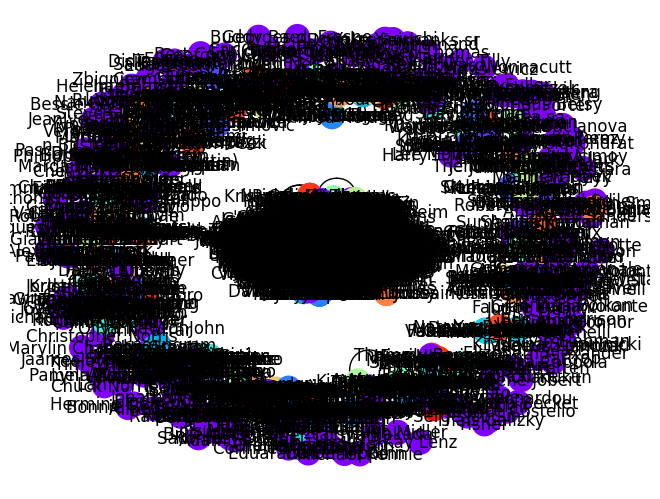

In [133]:
import matplotlib.pyplot as plt
import scipy as sc

# visualize communities and output them into log file
def communities(G, outputFileName = "../results/communitiesOutput.txt"):
    communities = {node: communityId + 1 for communityId , community in enumerate(nx.algorithms.community.k_clique_communities(G,3)) for node in community}
    for actor, communityId in communities.items():
        G.nodes[actor]['communityId'] = communityId
    with open(outputFileName, "w") as outputFile:
        pprint.pprint(communities, outputFile)
    pos = nx.spring_layout(G)
    nx.draw(G, pos,
        labels={v: str(v) for v in G},
        cmap = plt.get_cmap("rainbow"),
        node_color=[communities[v] if v in communities else 0 for v in G])
    
    
communities(graph)

## Kevin Bacon's number

In [134]:
import math

# compute Kevin Bacon number - shortest path to kevin bacon and its average
def kevinBaconNumber(G, actor = "Kevin Bacon"):
    shortestPaths = nx.single_source_shortest_path_length(G, actor)
    for actor in G.nodes():
        G.nodes[actor]["KevinBaconNumber"] = math.inf
        
    shortestPathsSum = 0
    for actor, shortestPath in shortestPaths.items():
        G.nodes[actor]["KevinBaconNumber"] = shortestPath
        shortestPathsSum += shortestPath
        
    print(f'Average Kevin Bacon number of nodes with finite Kevin Bacon number: {shortestPathsSum / len(shortestPaths)}')
    print(f'Number of nodes with finite Kevin Bacon number: {len(shortestPaths)}')
    

kevinBaconNumber(graph)

Average Kevin Bacon number of nodes with finite Kevin Bacon number: 3.6641509433962263
Number of nodes with finite Kevin Bacon number: 5035


## Create `.gexf` file

In [ ]:
# save graph to file
nx.write_gexf(graph, '../results/graph.gexf')

## Visualization

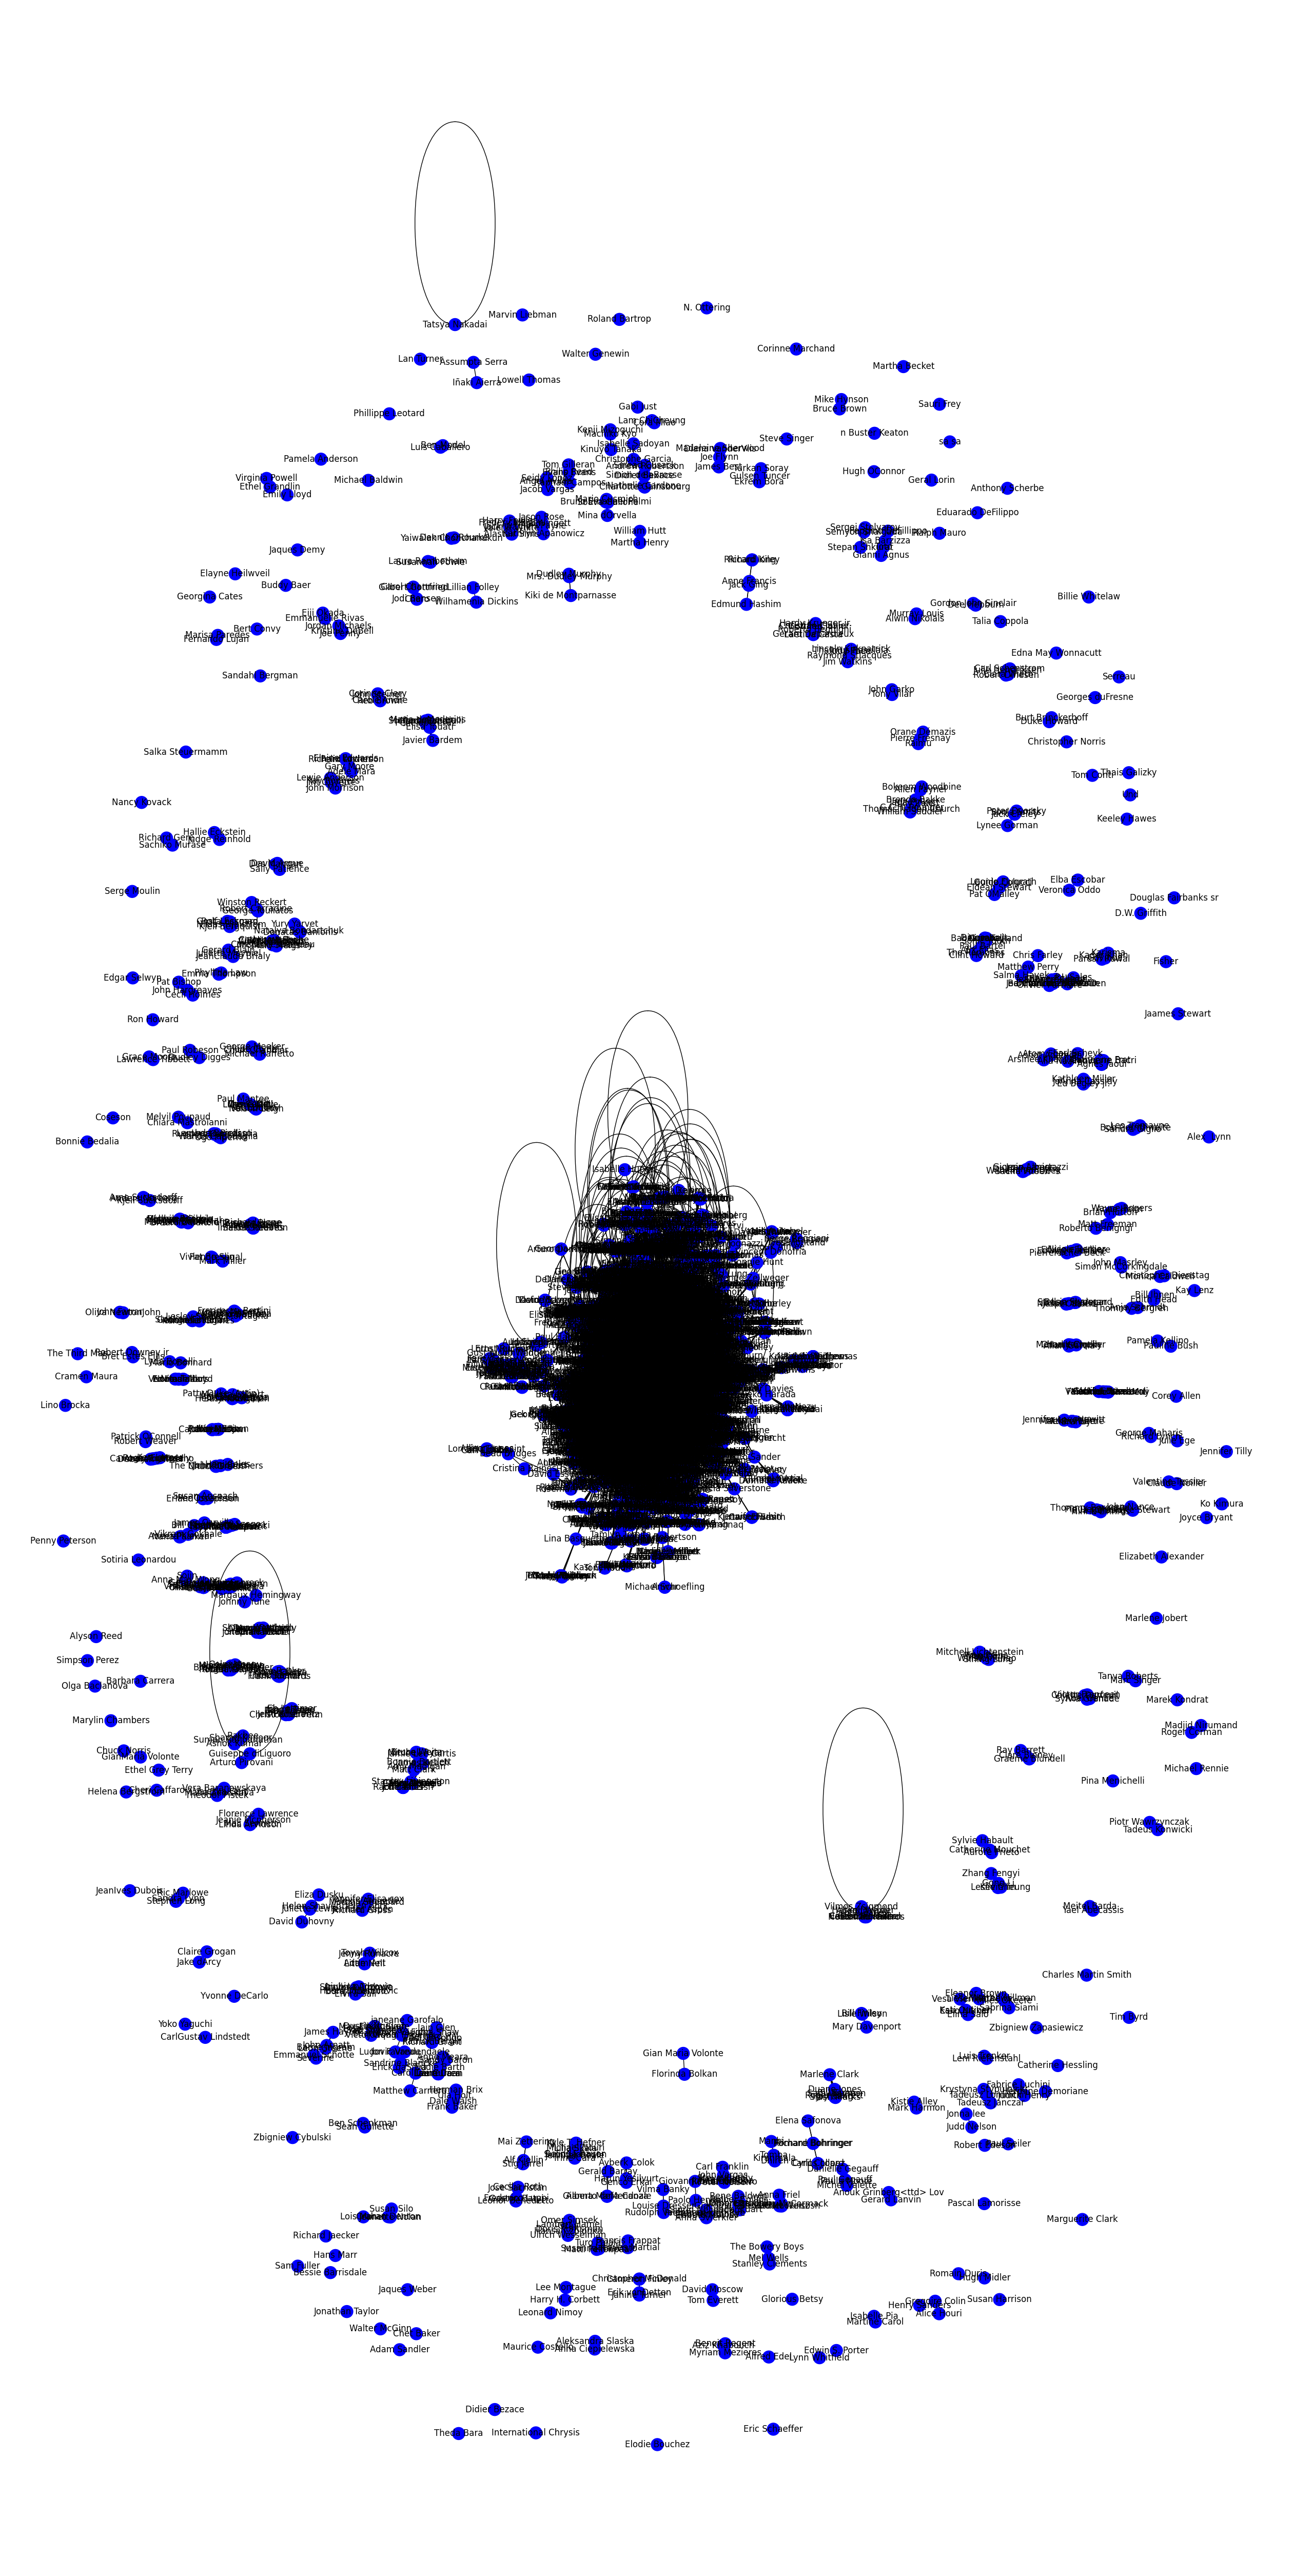

In [128]:
plt.figure(figsize=(25,50))
nx.draw_spring(graph,
               cmap=plt.get_cmap("bwr"),
               node_color=[graph.degree(node) for node in graph], 
               with_labels=True)

Computing transition probabilities: 100%|██████████| 5832/5832 [00:15<00:00, 369.70it/s]
31269.91s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
31269.96s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
31269.97s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
31269.98s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debu

KeyError: nan

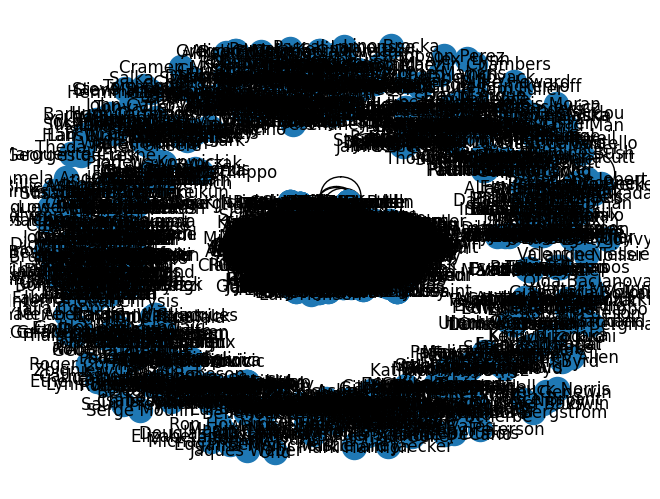

In [138]:
from node2vec import Node2Vec
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt

nx.draw(graph, with_labels=True)

# node2vec
node2vec = Node2Vec(graph, dimensions=50, walk_length=15, num_walks=200, workers=4)
model = node2vec.fit(window=5, min_count=1, batch_words=4)

# visualize
pca = PCA(n_components=2)
pca_comps = pca.fit_transform(model.wv.vectors)
plt.figure(figsize=(25, 50))
plt.scatter(pca_comps[:, 0], pca_comps[:, 1], c='blue')
for name, x, y in zip(graph.nodes(), pca_comps[:, 0], pca_comps[:, 1]):
        plt.annotate(name, xy=(x, y), size=15)